In [39]:
import re
import random
import pandas as pd
import hashlib

In [40]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [41]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,65.717979,3.458841,10.357732,19
IW Migration,228.594961,45.718992,60.448660,5
RAG Project,498.929533,31.183096,45.763179,16
Azure AD Authentication,719.481468,55.344728,111.525520,13
Azure Functions + Visual Studio,946.032803,72.771754,277.067340,13
Email Auth and Security,964.614806,80.384567,197.709762,12
Azure DevOps Pipelines,975.937598,37.536061,100.673363,26
Open Source/GitHub,1066.794679,66.674667,182.062328,16
Todd Ideas,1079.793227,107.979323,270.574983,10
Asynchronous Python,1088.945902,23.672737,40.479709,46


# Histogram

sum of ages: ~43847.12


<Axes: >

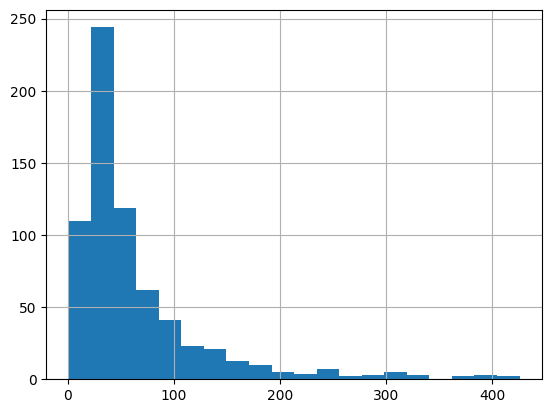

In [42]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [43]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [44]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [45]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [46]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [47]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [48]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [49]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [50]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [51]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 679
Total card age: 43847.12


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
165,Todd Ideas,"In Azure AI Document Intelligence, you can int...",6b9f148cae856ab45115d526d9999a26,-270.574983,-107.979323,270.574983,1079.793227,0.323016,0,0
166,Todd Ideas,"In Azure AI Document Intelligence, Custom mode...",3f57b9c4af8b19aabadde975a94e8b99,-133.635460,-107.979323,270.574983,1079.793227,0.323016,3,0
167,Todd Ideas,"In Azure AI Document Intelligence, prebuilt mo...",9f89fcf65ed6d5dc5f702007d8d74121,-46.039912,-107.979323,270.574983,1079.793227,0.323016,6,0
168,Todd Ideas,The most common way to authenticate access to ...,18150edd597bdc1ca0a2f0fb94045c8a,-18.519209,-107.979323,270.574983,1079.793227,0.323016,9,0
56,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-380.160614,-107.855638,380.160614,3774.947319,0.646470,0,0
57,Logging in Python,Q: What is the advantage of using logging.getL...,e63d3ef375f4f0905315b7f337ed7eff,-279.672001,-107.855638,380.160614,3774.947319,0.646470,3,0
58,Logging in Python,Q: How can you include exception tracebacks in...,6a344b1ab62495533fc42ded0c61a8d8,-166.356361,-107.855638,380.160614,3774.947319,0.646470,6,0
59,Logging in Python,Q: Which logging level is appropriate for a me...,34aa335f159554e1fa43ef4942a6303b,-143.103721,-107.855638,380.160614,3774.947319,0.646470,9,0
60,Logging in Python,Q: What should you do to ensure that logging.b...,4d3218f8dc6a67fac7f558d2f82b88a1,-137.219864,-107.855638,380.160614,3774.947319,0.646470,12,0
61,Logging in Python,Q: Why should log files be secured with approp...,dd529ab0ee580346b944822dbffb1e10,-79.279339,-107.855638,380.160614,3774.947319,0.646470,15,0


## Age Max

In [52]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [53]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [54]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [55]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
229,Azure Developer Associate,Q: Which tiers of Azure Cache for Redis are ba...,1dfb97906449c201f5bdfcd75cba1819,-425.595436,-67.774258,425.595436,4066.455471,0.712720,0,0
32,PnP PowerShell,Server Relative URL\nThe URL path relative to ...,8cf299b28aba8eeb49c675bc6fd23204,-407.428421,-54.291794,407.428421,3909.009167,0.240357,0,0
458,Azure Developer Associate,Q: What are key benefits of using Redis?\nA: U...,ec6a9d42ac7d9a2d5436a6dac663fde1,-401.955675,-67.774258,425.595436,4066.455471,0.712720,1,1
149,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,-395.930369,-81.969680,395.930369,1557.423922,0.363577,0,0
270,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-384.147197,-54.291794,407.428421,3909.009167,0.240357,1,1
56,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-380.160614,-107.855638,380.160614,3774.947319,0.646470,0,0
161,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,-370.845733,-100.218618,370.845733,1202.623412,0.459393,0,0
14,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-337.899459,-78.520134,337.899459,4161.567089,0.826308,0,0
498,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-334.524296,-54.291794,407.428421,3909.009167,0.240357,2,2
156,WSL + Kali Linux,/etc/wsl.conf\nA configuration file in Linux d...,d7247497d7a6816591f382a140abb013,-321.304314,-102.143584,321.304314,1430.010176,0.900201,0,0


In [56]:
existing_cards.head(10).sum()

head                   Todd IdeasTodd IdeasTodd IdeasTodd IdeasLoggin...
body                   In Azure AI Document Intelligence, you can int...
hash                   6b9f148cae856ab45115d526d9999a263f57b9c4af8b19...
age                                                         -1654.561464
subject_mean_age                                            -1079.051117
subject_highest_age                                          3363.263613
subject_age_sum                                             26968.856821
head_random_roll                                                 5.17088
count                                                                 63
n_fold                                                                 0
dtype: object

In [57]:
existing_cards['age'].mean()

-64.57602272503088